## 1. 最优模型

### 1.1 如何改善模型？

如果模型表现低于预期，如何提升？

1. 使用更复杂的模型
2. 使用更简单的模型
3. 增加样本观测值
4. 增加/减少特征

### 1.2 如何定义最优模型？

"最优"的简单理解：模型既没有过度拟合数据，也没有拟合不足，并且有很强的预测能力。

下图展示了一个简单的案例。左图用直线拟合明显不是线性关系的两个数值变量，右图用高阶多项式拟合。简单的线性回归并没有完全捕捉变量间的关系，简称"拟合不足"，预测能力一般。复杂的多项式回归完美地拟合了数据，但预测能力非常差，简称"过度拟合"。

最优模型应该处于两者之间，既没有拟合不足，也没有过度拟合。

![过度拟合 vs 拟合不足](../pic/underfit_vs_overfit.png)

## 2. 验证曲线

### 2.1 如何理解验证曲线？

验证曲线(validation curve): 描述模型复杂度和预测能力的曲线。

典型的验证曲线如下图：

![validation_curve](../pic/validation_curve.png)

横轴表示模型的复杂度，纵轴是性能评估分数，蓝色曲线描述模型在训练集的评分，红色曲线描述检验集的评分。一般情况下，模型越复杂，对训练集的拟合越好，但预测能力却因过度拟合而逐渐下降。最优模型处于红色曲线的峰谷。

### 2.2 如何用sklearn实现验证曲线？

1. 选择模型(1个)。
2. 选择参数和扫描区间。
3. 调用sklearn.model_selection.validation_curve接口。
4. 计算训练得分和检验得分的平均值。
5. 绘制验证曲线，选择最优模型。

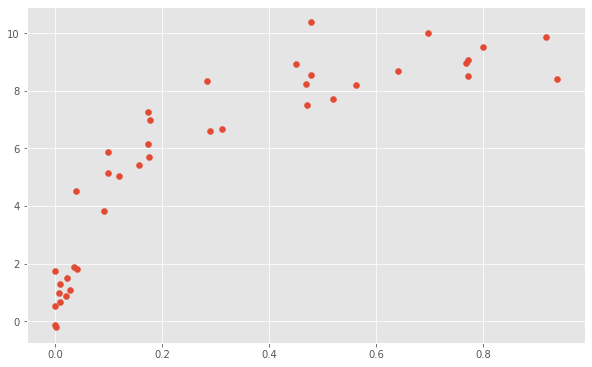

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# 创建数据集
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

# 可视化
fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:, 0], y, marker="o")

In [2]:
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 1. 选择模型，以多项式回归为例
def polynomial_regression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# 2. 选择参数和扫描区间，参数是degree，决定了多项式的阶数
degree_rng = np.arange(0, 21)

# 3. 调用validation_curve()
train_scores, test_scores = validation_curve(
    estimator=polynomial_regression(),
    X=X,
    y=y,
    param_name="polynomialfeatures__degree",  # 参数名字，调用model.get_params().keys()查看参数名字
    param_range=degree_rng,  # 参数扫描区间
    cv=5  # 交叉验证的折数
)

train_scores, test_scores记录训练评分和检验评分(这里的评分是可决系数$R^2$)，它们都是$M*N$矩阵，M是拟合模型的数量，N是交叉验证折数。

In [3]:
train_scores

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.71469019, 0.71586162, 0.76727921, 0.70766539, 0.71499241],
       [0.89413781, 0.88248815, 0.90829697, 0.87972563, 0.90847575],
       [0.92520846, 0.93334   , 0.95899026, 0.91606433, 0.93572634],
       [0.93587084, 0.95074453, 0.96604063, 0.93028939, 0.94435724],
       [0.93915599, 0.95185182, 0.96605692, 0.93089664, 0.94645919],
       [0.94141775, 0.95246147, 0.96773124, 0.93286909, 0.94755474],
       [0.94297978, 0.95302912, 0.96774457, 0.93366267, 0.95200763],
       [0.94298132, 0.95381995, 0.96889269, 0.93369183, 0.95227903],
       [0.94866279, 0.95442657, 0.97067738, 0.93686825, 0.95236701],
       [0.94867303, 0.95638686, 0.97392267, 0.93983835, 0.95528966],
       [0.94918109, 0.9563877 , 0.97394995, 0.94264752, 0.95966939],
       [0.95675049, 0.96287427, 0.97395   , 0.94345827, 0.96035077],
       [0.9589008 , 0.96517089, 0.97628315, 0.94435956, 0.96035174],
       [0.95920027, 0.96605177, 0.

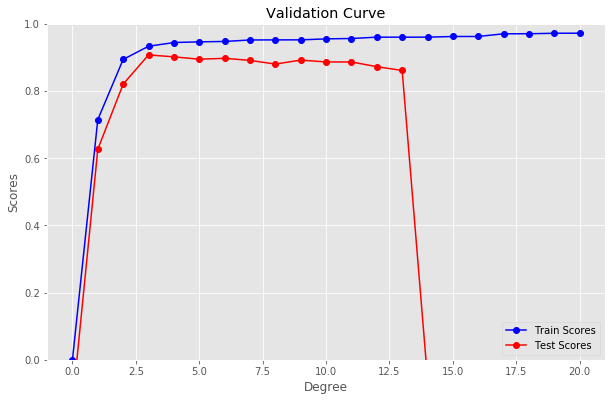

In [4]:
# 4. 计算每个模型的平均训练得分和验证得分
train_scores_median = np.median(train_scores, axis=1)
test_scores_median = np.median(test_scores, axis=1)

# 5. 绘制验证曲线，x轴是优化的参数，代表模型复杂度，y轴是性能评分
fig, ax = plt.subplots(figsize=(10, 6.18))
ax.plot(degree_rng, train_scores_median, marker="o", color="blue", label="Train Scores")
ax.plot(degree_rng, test_scores_median, marker="o", color="red", label="Test Scores")
ax.set(ylim=(0, 1), xlabel="Degree", ylabel="Scores", title="Validation Curve")
ax.legend()

上图展示的信息与预期相符：

* 训练得分通常高于检验得分。
* 训练得分是模型复杂度的单调递增函数。
* 检验得分随着模型复杂度的提升先上升后下降。

最优模型处在训练得分最高点，degree=3 or 4.

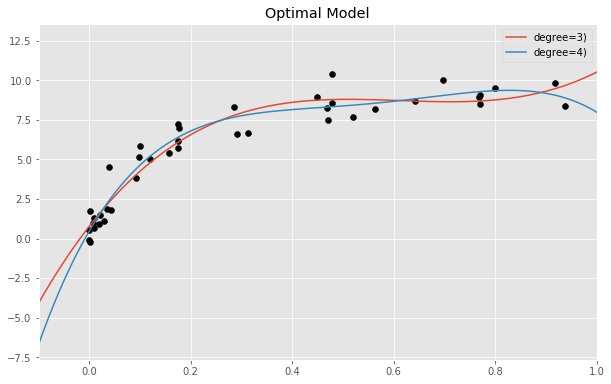

In [5]:
X_test = np.linspace(-0.1, 1.1, 500).reshape(500, 1)

fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X.ravel(), y, marker="o", color="black")

for degree in [3, 4]:
    y_test = polynomial_regression(degree).fit(X, y).predict(X_test)
    ax.plot(X_test.ravel(), y_test, label=f"degree={degree})")
    
ax.set(xlim=(-0.1, 1.0), title="Optimal Model")
ax.legend()

## 3. 学习曲线

### 3.1 如何理解学习曲线？

学习曲线(Learning Curve): 描绘训练评分/检验评分和训练集大小关系的曲线。

如下图所示，横轴是训练集大小，纵轴是训练/检验评分。

给定模型复杂度：

1. 训练评分(蓝色曲线)随着样本变大而下降，当样本很小时，模型会完全拟合数据，但随者样本增加，模型对数据的拟合程度会下降。
2. 检验评分(红色曲线)随着样本变大而上升。
3. 训练评分高于检验评分。
4. 随着训练集变大，两条曲线可能收敛。

若两条曲线收敛于某点，这意味着对于给定的模型，只要训练集大小超过了临界值，继续增加样本将无法改善模型性能。

![Learning Curve](../pic/learning_curve.png)

### 3.2 如何用sklearn实现学习曲线？

1. 选择模型(复杂度保持不变)
2. 决定训练集大小，可以选择比例，也可以给定包括观测值个数的数组
3. 调用model_selection.learning_curve接口，提供交叉验证折数
4. 计算在每一个给定训练集大小下的平均训练得分和检验得分
5. 绘图，x轴是训练集大小，y轴是模型评分

In [6]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=polynomial_regression(degree=4),  # 给定复杂度的模型
    X=X,
    y=y,
    train_sizes=np.linspace(0.2, 1, 10),  # 按比例划分训练集
    cv=5  # 交叉验证折数
)

train_sizes是训练集大小，包括了每一次训练模型的观测值数量。

In [7]:
train_sizes

array([ 6,  9, 12, 14, 17, 20, 23, 26, 29, 32])

train_scores, test_scores都是$M*N$矩阵，M是训练集大小，N是交叉验证折数。

In [8]:
print(train_scores.shape)
print(test_scores.shape)
print(train_scores)

(10, 5)
(10, 5)
[[0.99999785 0.99394217 0.99394217 0.99394217 0.99394217]
 [0.96977265 0.98224551 0.98127898 0.98127898 0.98127898]
 [0.92474504 0.92138354 0.96722183 0.96722183 0.96722183]
 [0.92944525 0.94530394 0.97203892 0.97203892 0.97203892]
 [0.9114376  0.92346656 0.96410732 0.96019957 0.96019957]
 [0.93237596 0.94193826 0.97084939 0.93103082 0.93103082]
 [0.94073524 0.94740255 0.97301345 0.93745262 0.93745262]
 [0.93707836 0.95009311 0.97223835 0.92616659 0.93256037]
 [0.92869726 0.946726   0.96576659 0.91948484 0.94173119]
 [0.93587084 0.95074453 0.96604063 0.93028939 0.94435724]]


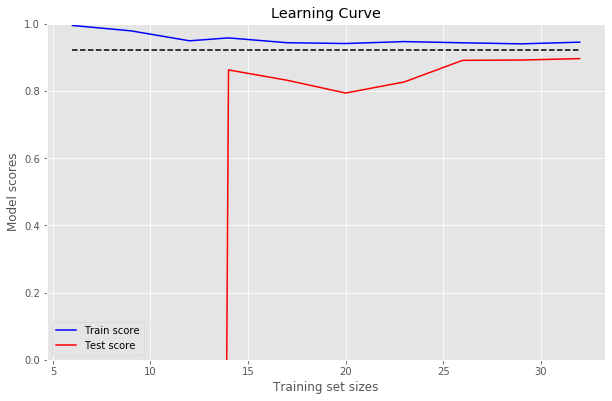

In [9]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

convergence_point = np.mean([train_scores[-1], test_scores[-1]])

fig, ax = plt.subplots(figsize=(10, 6.18))
ax.plot(train_sizes, train_scores_mean, color="blue", label="Train score")
ax.plot(train_sizes, test_scores_mean, color="red", label="Test score")
ax.hlines(convergence_point, xmin=train_sizes[0], xmax=train_sizes[-1], linestyles="dashed")
ax.set(ylim=(0, 1), xlabel="Training set sizes", ylabel="Model scores",
       title="Learning Curve")
ax.legend()

## 4. 网格搜索

### 4.1 什么是网格搜索？

网格搜索(Grid Search)：用暴力突破的办法寻找最优模型。选择参数和扫描区间，测试所有组合，选择预测能力最高的参数组合，最后得到的模型视为最优模型。

当数据集很大或参数很多时，网格搜索的效率比较低，查看官方文档学习更高效的方法。

https://scikit-learn.org/stable/modules/grid_search.html

### 4.2 如何用sklearn实现网格搜索？

1. 选择模型
2. 选择参数和扫描区间
3. 调用model_selection.GridSearchCV接口
4. 选择预测能力最高的参数组合

In [10]:
from sklearn.model_selection import GridSearchCV

In [24]:
from pprint import pprint

# 选择模型，调用get_params方法查看所有参数
estimator = polynomial_regression()
pprint(estimator.get_params())

{'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': False,
 'memory': None,
 'polynomialfeatures': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C'),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'steps': [('polynomialfeatures',
            PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')),
           ('linearregression',
            LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))],
 'verbose': False}


In [25]:
# 决定参数和扫描区间(即参数的取值范围)
# 必须提供字典，键是参数名字，值是扫描区间
param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]
}

# 调用GridSearchCV接口
grid = GridSearchCV(
    estimator=estimator, # 提供模型
    param_grid=param_grid, # 提供参数和扫描区间
    cv=5  # 交叉验证折数
)

# 拟合数据，开始搜索
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                        

In [26]:
## 查看最优参数和模型
print(grid.best_params_)
print(grid.best_estimator_)

{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'polynomialfeatures__degree': 4}
Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
